# Figure 12. HBM simulations (orientation)

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np 
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from data import load_data
from utils import compute_ensemble_bias, vonmises_pdf, circmean, compute_trial_mean, round_df_angles, min_angle, compute_bias_ols
from vis import FREE_ORIENT, RAND_ORIENT, plot_ensemble_bias_by_response, plot_ensemble_bias_by_set_size, get_colorwheel, set_axes_rad, set_export_style, set_axes_aspect, plot_hbm_illustration, plot_data_bias, paired_hist, plot_shaded_error, FREE_COLOR, RAND_COLOR, KAPPA_OBS_PALETTE, plot_model_bias, plot_bias_ols_by_response, plot_bias_ols_by_k
from models import fit_vm_by_sub, load_hbm_fit, compute_relative_error, phase_locked_sine, fit_phase_locked_sine, bootstrap_sine_fit, bootstrap_sine_fit_by_sub

save_fig = False

### Load data

In [2]:
## Data loading ##
modality = 'orient'

# continuous datasets
df_free_cont = load_data(modality=modality, condition='free', dataset='continuous')
df_rand_cont = load_data(modality=modality, condition='rand', dataset='continuous')

In [3]:
# load and process hbm fits for plotting; concatenate into single dataframe 
# (takes a while...)

condition = 'free' # just 1 cond. for the model bc there's no report order difference
datasets = ['continuous']
kappas = [5, 10, 20]
set_sizes = [3]
var_list=['presented_rad', 'theta_hat']
trial_var_list=['mu_hat', 'kappa_hat']

df_list = []
for dataset in datasets:
    for kappa_obs in kappas:
        for set_size in set_sizes:
            temp_df = load_hbm_fit(modality, condition, dataset, set_size, kappa_obs)
            temp_df = compute_trial_mean(temp_df, var_list=var_list,                 
                                        trial_var_list=trial_var_list,
                                        is_response_df=False)
            temp_df['kappa_obs'] = kappa_obs
            temp_df['dataset'] = dataset
            n_angles = 360 if dataset == 'continuous' else 8
            temp_df = round_df_angles(temp_df, var='theta_hat', n_angles=n_angles)
            df_list.append(temp_df)
    
df_fit = pd.concat(df_list)

### Figure 12A (upper). Continuous HBM model bias

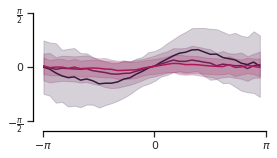

In [11]:
# plot ss3 model bias (continuous)
df = df_fit[(df_fit['set_size'] == 3) & (df_fit['dataset'] == 'continuous')]

fig, ax = plot_model_bias(df, bins=36, fit_sin=False)
set_export_style(fig, [ax], figsize=(4, 2))
ax.spines['left'].set_position(('outward',10))
ax.spines['bottom'].set_position(('outward',10))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

if save_fig:
    plt.savefig('../figures/fig_S05-01_hbm_bias_ss3_cont.png', bbox_inches='tight', dpi=800)

### Figure 12B (upper). Orientation data bias

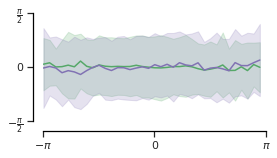

In [12]:
# plot ss3 data bias (continuous)
df_free_cont = compute_trial_mean(df_free_cont[df_free_cont['set_size'] == 3])
df_rand_cont = compute_trial_mean(df_rand_cont[df_rand_cont['set_size'] == 3])

fig, ax = plot_data_bias(df_free_cont, df_rand_cont, bins=36, var='reported_rad', 
                   bias_toward='presented_rad_mean', fit_sin=False, palette=[FREE_ORIENT, RAND_ORIENT])

set_export_style(fig, [ax], figsize=(4, 2))
ax.spines['left'].set_position(('outward',10))
ax.spines['bottom'].set_position(('outward',10))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

if save_fig:
    plt.savefig('../figures/fig_S05-02_data_bias_ss3_cont.png', bbox_inches='tight', dpi=800)

### Figure 12A (lower). Continuous HBM model bias

In [ ]:
df = df_fit[(df_fit['set_size'] == 3) & 
            (df_fit['dataset'] == 'continuous') & 
            (df_fit['response'] == 1)]
df['relative_mean'], df['relative_error'] = compute_relative_error(df,         
                                            var='theta_hat',
                                            bias_toward='presented_rad_mean')

scatter_kws = {'s': 10, 'alpha': 0.25}
line_kws = {'color': 'k', 'linewidth': 1.5, 'linestyle': '--'}
fig, axes, g = plot_bias_ols_by_k(df, x_var='relative_mean', 
                                         y_var='relative_error', 
                                         x_range=[-np. pi / 2, np.pi / 2],
                                         scatter_kws=scatter_kws, 
                                         line_kws=line_kws,
                                         stats=False, 
                                         sharey=False,
                                         sharex=False)

fig.set_size_inches((6, 2))

for ind, ax in enumerate(axes):
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim([-np.pi - 0.1, np.pi + 0.1])
    ax.set_yticks([-np.pi, 0, np.pi])
    ax.set_yticklabels([r'$-\pi$', '0', r'$\pi$'])
    ax.set_xticks([-np.pi / 2, 0, np.pi/2])
    ax.set_xlim([-np.pi / 2 - 0.05, np.pi / 2 + 0.05])
    ax.set_xticklabels([r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$'])
    ax.spines['left'].set_position(('outward',10))
    ax.spines['left'].set_bounds((-np.pi, np.pi))
    ax.spines['bottom'].set_position(('outward',10))
    ax.spines['bottom'].set_bounds((-np.pi / 2, np.pi / 2))

    if ind != 0:
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)

if save_fig:
    plt.savefig('../figures/fig_S05-03_model_bias_ss3_cont.png', bbox_inches='tight', dpi=800)

In [7]:
def plot_bias_ols(data, x_var, y_var, x_range=[-np.pi, np.pi], stats=True, palette=[FREE_COLOR, RAND_COLOR],
                              scatter_kws={'s': 10, 'alpha': 0.5}, line_kws=None, **kwargs):
    """ Plot regression results by response for data
    One set size, free & rand combined
    """
    data = data[(data[x_var] > x_range[0]) & (data[x_var] < x_range[1])]

    g = sns.lmplot(data=data, x=x_var, y=y_var, col='condition', 
                   hue='condition', palette=palette, 
                   legend=False, scatter_kws=scatter_kws, line_kws=line_kws, **kwargs)

    fig = plt.gcf() 
    axes = np.array(g.axes.flat)
            
    return fig, axes, g

### Not published. Orientation data bias (all responses, set size 3)

/home/benc/phd/cuthbert-et-al-2020/venv/lib/python3.10/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/benc/phd/cuthbert-et-al-2020/venv/lib/python3.10/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


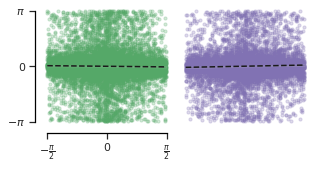

In [14]:
# plot data bias (continuous)
df_free_cont['condition'] = 'free'
df_rand_cont['condition'] = 'rand'

df = pd.concat([df_free_cont, df_rand_cont]).reset_index(drop=True)
df['relative_mean'], df['relative_error'] = compute_relative_error(df,         
                                            var='reported_rad',
                                            bias_toward='presented_rad_mean')

scatter_kws = {'s': 10, 'alpha': 0.25}
line_kws = {'color': 'k', 'linewidth': 1.5, 'linestyle': '--'}
fig, axes, g = plot_bias_ols(df, x_var='relative_mean', 
                                         y_var='relative_error', 
                                         x_range=[-np. pi / 2, np.pi / 2],
                                         scatter_kws=scatter_kws, 
                                         line_kws=line_kws,
                                         palette=[FREE_ORIENT, RAND_ORIENT],
                                         stats=False, 
                                         sharey=False,
                                         sharex=False)
fig.set_size_inches((4, 2))

for ind, ax in enumerate(axes):
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim([-np.pi - 0.1, np.pi + 0.1])
    ax.set_yticks([-np.pi, 0, np.pi])
    ax.set_yticklabels([r'$-\pi$', '0', r'$\pi$'])
    ax.set_xticks([-np.pi / 2, 0, np.pi/2])
    ax.set_xlim([-np.pi / 2 - 0.05, np.pi / 2 + 0.05])
    ax.set_xticklabels([r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$'])
    ax.spines['left'].set_position(('outward',10))
    ax.spines['left'].set_bounds((-np.pi, np.pi))
    ax.spines['bottom'].set_position(('outward',10))
    ax.spines['bottom'].set_bounds((-np.pi / 2, np.pi / 2))

    if ind != 0:
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)

if save_fig:
    plt.savefig('../figures/fig_S05-04_data_bias_ss3_cont.png', bbox_inches='tight', dpi=800)

### Figure 12B (lower). Orientation data bias

/home/benc/phd/cuthbert-et-al-2020/venv/lib/python3.10/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/benc/phd/cuthbert-et-al-2020/venv/lib/python3.10/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


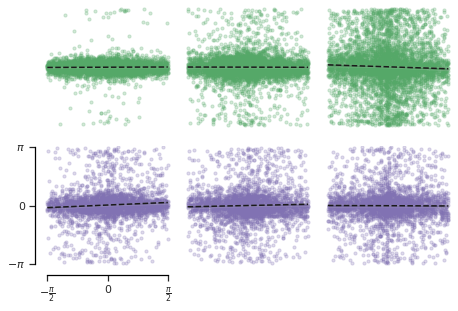

In [15]:
# plot data bias by response (continuous)
df_free_cont['condition'] = 'free'
df_rand_cont['condition'] = 'rand'

df = pd.concat([df_free_cont, df_rand_cont]).reset_index(drop=True)
df['relative_mean'], df['relative_error'] = compute_relative_error(df,         
                                            var='reported_rad',
                                            bias_toward='presented_rad_mean')

scatter_kws = {'s': 10, 'alpha': 0.25}
line_kws = {'color': 'k', 'linewidth': 1.5, 'linestyle': '--'}
fig, axes, g = plot_bias_ols_by_response(df, x_var='relative_mean', 
                                         y_var='relative_error', 
                                         x_range=[-np. pi / 2, np.pi / 2],
                                         scatter_kws=scatter_kws, 
                                         line_kws=line_kws,
                                         palette=[FREE_ORIENT, RAND_ORIENT],
                                         stats=False, 
                                         sharey=False,
                                         sharex=False)
fig.set_size_inches((6, 4))

for ind, ax in enumerate(axes):
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim([-np.pi - 0.1, np.pi + 0.1])
    ax.set_yticks([-np.pi, 0, np.pi])
    ax.set_yticklabels([r'$-\pi$', '0', r'$\pi$'])
    ax.set_xticks([-np.pi / 2, 0, np.pi/2])
    ax.set_xlim([-np.pi / 2 - 0.05, np.pi / 2 + 0.05])
    ax.set_xticklabels([r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$'])
    ax.spines['left'].set_position(('outward',10))
    ax.spines['left'].set_bounds((-np.pi, np.pi))
    ax.spines['bottom'].set_position(('outward',10))
    ax.spines['bottom'].set_bounds((-np.pi / 2, np.pi / 2))

    if ind != 3:
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)

if save_fig:
    plt.savefig('../figures/fig_S05-09_data_bias_ss3_cont.png', bbox_inches='tight', dpi=800)